<center><h1>Automated Colorization of Images</h1></center>

<center>Harsh Vashistha, Deepanjan Bhattacharyya, Bharat Prakash</center>
<center>{harsh5, deep8, bh1} @umbc.edu</center>
<hr/>
<br/><br/>
<center>
Project for Data Science course ([CMSC 491/691](https://www.csee.umbc.edu/~kalpakis/courses/491-fa17/))
</center>
<center>
[Project Slides](resources/slides.pdf)
</center>
<center>
Data Set - [ImageNet fall 11 URLs](http://image-net.org/imagenet_data/urls/imagenet_fall11_urls.tgz)
</center>

## Project Introduction

Converting a black & white image to color is a tedious task

There are multiple issues which needs to be tackled to create a good model. Some of these limitations and issues are: 
* Too many objects and varying textures.
* Each object  or part of image can take on different colors. 
* The problem is under-constrained and can have multiple solutions.

| GrayScale Input | A possible color for image | Another possible color for the image |
|:---:|:---:|:---:|
| <img src="resources/intro_bnw.png" style="width:300px; height:200px; vertical-align:bottom; display:inline-block;"/> | <img src="resources/intro_c1.png" style="width:300px; height:200px; vertical-align:bottom; display:inline-block;"/> | <img src="resources/intro_c2.png" style="width:300px; height:200px; vertical-align:bottom; display:inline-block;"/> |



In [1]:
# Setting up environment variable for code which needs to run only from jupyter notebook

__IPython__ = True
try:
    get_ipython        
except NameError:
    __IPython__ = False

if __IPython__:
    %matplotlib inline

Minsky/BlueSpeed Server has **tensorflow v1.3** as latest available version while Keras uses tensorflow v1.4 for
```multi_gpu_model``` call.
The only missing function which cause conflicts is ```tf.Session.sess.list_devices()``` which is in v1.3 is ```device_lib.list_local_devices()```
Creating a dummy below

In [3]:
from tensorflow.python.client import device_lib
from keras import backend as K

def get_local_devices():
    local_devices = device_lib.list_local_devices()
    for device in local_devices:
        device.name = device.name.replace('/', 'device:')
    return local_devices

sess = K.get_session()
sess.list_devices = get_local_devices

In [4]:
import os, sys, threading

import numpy as np
import tensorflow as tf

import keras
from keras.utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers.core import RepeatVector, Permute
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.initializers import TruncatedNormal
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

import matplotlib.pyplot as plt

We are training our model on a multi-GPU server and hence the data generator needs to be thread safe.
```threadsafe_generator``` below provides the functionality in the form of a decorator.

```batch_apply``` Applies function func to batch provided as numpy.ndarray

Architecture of Minsky:
* 2 Power-8 nodes with 10 Cores each
* Each Core supports upto 8 threads
* 4 Nvidia Tesla P100 GPUs, interconnnected with NVlinks and CPU:GPU NVlinks
* 1 TB of Flash RAM

In [5]:
# Helper functions and classes

def batch_apply(ndarray, func, *args, **kwargs):
    """Calls func with samples, func should take ndarray as first positional argument"""

    batch = []
    for sample in ndarray:
        batch.append(func(sample, *args, **kwargs))
    return np.array(batch)


class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

### Model Pipeline Architecture <sup><a href="#References">[1]</a></sup> [citation](https://github.com/baldassarreFe/deep-koalarization/blob/master/paper.pdf)

<img src="resources/network.png" />

The model architecture is much like __Auto-Encoders__. The first part is an __Encoder__. The last part is __Decoder__. 

It's the central part, the fusion layer, which is a little different. Fusion layer takes output from the __Encoder__ and the embeddings generated by __Inception-ResNet-V2 model__ and concatenates both the outputs before continuing. This Inception-ResNet-V2 model is pre-trained on [ImageNet](http://www.image-net.org/) dataset.

The embeddings from Inception-ResNet-v2 are replicated as shown in diagram above to match output size of Encoder. 
> Replicating the embeddings also attaches the same information to all the pixel outputs of Encoder and hence is present spatially on the whole image. <sup><a href="#References">[1]</a></sup>

<hr/>
We will be using [Keras](http://keras.io) as higher level framework to build our model and [tensorflow](http://www.tensorflow.org) as it's backend.


Start by downloading the Inception-ResNet-V2 model from keras along with the model weights

In [6]:
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

In [7]:
def create_inception_embedding(grayscaled_rgb):
    '''Takes (299, 299, 3) RGB and returns the embeddings(predicions) generated on the RGB image'''
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb)
    return embed

### Auto Encoder Graph

Create the auto-encoder in CPU memory. Doing this stores the weights of the model in CPU memory. These weights are shared among all the replicas for multiple GPU architecture, created later in the notebook.

In [8]:
with tf.device('/cpu:0'):
    #Inputs
    embed_input = Input(shape=(1000,))
    encoder_input = Input(shape=(256, 256, 1,))
    
    #Encoder
    encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2,
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_input)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2,
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2,
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(fusion_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(32, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_output)
    decoder_output = Conv2D(16, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    
    model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

__ImageDataGenerator__, a keras utility, provides real-time data augmentation by performing simple tranformations on the image. This also helps in generalizing the network towards shapes and orientations. It also increses the training data size.

In [9]:
datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, rotation_range=20, horizontal_flip=True)

Images are converted from __```RGB```__ profile to __```CIE L*a*b*```__ color profile.<br/>
__```RGB```__ has three channels corresponding to the three primary colors (Red, Green and Blue).<br/>
While,<br/>
__```L*a*b*```__ has three channels Corresponding to L for lightness, a and b for the color spectra green–red and blue–yellow.

The advantage of using ```L*a*b*``` is that Lightness channel which is the black & white image and the color channels are separate. This gives us the convenience to combine the black & white input with the ```a*b*``` color channels at the output.

__Eg:__ <br />
<img src="http://shutha.org/sites/default/files//uploads/3_Courses/3_Digital_Imaging/02%20LAB1b.jpg" style="height:500px; display:inline-block; float:left;" />&nbsp;&nbsp;&nbsp;__becomes__&nbsp;&nbsp;&nbsp;
<img src="http://shutha.org/sites/default/files//uploads/3_Courses/3_Digital_Imaging/02%20LAB2b.jpg" style="height:500px; display:inline-block; float:right;" />

#### Color Space ranges:

``RGB``
```python 
{'R': [0, 255], 'G': [0, 255], 'B': [0, 255]} # type(int)
or
{'R': [0.0, 1.0], 'G': [0.0, 1.0], 'B': [0.0, 1.0]} # type(float)
```

``L*a*b*``
```python
{'L*': [0.0, 100.0], 'a*': [-128.0, 128.0], 'b*': [-128.0, 128.0]} # type(float)
```

In [10]:
# Convert images to LAB format and resizes to 256 x 256 for Encoder input.
# Also, generates Inception-resnet embeddings and returns the processed batch

def process_images(rgb, input_size=(256, 256, 3), embed_size=(299, 299, 3)):
    """Takes RGB images in float representation and returns processed batch"""
    
    # Resize for embed and Convert to grayscale
    gray = gray2rgb(rgb2gray(rgb))
    gray = batch_apply(gray, resize, embed_size, mode='constant')
    # Zero-Center [-1, 1]
    gray = gray * 2 - 1
    # Generate embeddings
    embed = create_inception_embedding(gray)
    
    # Resize to input size of model
    re_batch = batch_apply(rgb, resize, input_size, mode='constant')
    # RGB => L*a*b*
    re_batch = batch_apply(re_batch, rgb2lab)
    
    # Extract L* into X, zero-center and normalize
    X_batch = re_batch[:,:,:,0]
    X_batch = X_batch/50 - 1
    X_batch = X_batch.reshape(X_batch.shape+(1,))
    
    # Extract a*b* into Y and normalize. Already zero-centered.
    Y_batch = re_batch[:,:,:,1:]
    Y_batch = Y_batch/128
    
    return [X_batch, embed], Y_batch

In [11]:
# Generates augmented dataset and feed it to the model during training
@threadsafe_generator
def image_a_b_gen(images, batch_size):
    while True:
        for batch in datagen.flow(images, batch_size=batch_size):
            yield process_images(batch)

### Dataset

Size: __12519__ images from [ImageNet](http://www.image-net.org) published in [fall_11 urls](http://image-net.org/imagenet_data/urls/imagenet_fall11_urls.tgz)

Data Split
* Train - 0.7225 (9044 images)
* Validation - 0.1275 (1597 images)
* Test - 0.15 (1878 images)

In [12]:
# Consist of 12k images from imagenet
DATASET = '../data/imagenet/'

# Get images file names
training_files, testing_files = train_test_split(shuffle(os.listdir(DATASET)), test_size=0.15)

def getImages(DATASET, filelist, transform_size=(299, 299, 3)):
    """Reads JPEG filelist from DATASET and returns float represtation of RGB [0.0, 1.0]"""
    img_list = []
    for filename in filelist:
        # Loads JPEG image and converts it to numpy float array.
        image_in = img_to_array(load_img(DATASET + filename))
        
        # [0.0, 255.0] => [0.0, 1.0]
        image_in = image_in/255
        
        if transform_size is not None:
            image_in = resize(image_in, transform_size, mode='reflect')

        img_list.append(image_in)
    img_list = np.array(img_list)
    
    return img_list

Convert our model to multi gpu model. This function replicates the model graph we created in CPU memory onto the number of GPUs provided.

We will be using __Mean Squared Error__ loss function to train the network.

Initial Learning rate set to 0.001

In [13]:
model = multi_gpu_model(model, gpus=4)
model.compile(optimizer=RMSprop(lr=1e-3), loss='mse')

### Training

While training we keep track of improvements on our model using __Validation Loss__ metrics.

During training, this metric score triggers following routines:
* Save the model on improvement in score
* Reduce Learning Rate by a factor of 0.1 if no improvements for cosequtive few epochs
* Stop training if we are not seeing any improvement at all for considerable amount of time
<hr/>
<center>
    <div><b>Sample Input Images</b></div>
    <img src="resources/bnw_1.png" style="width:150px; height:150px; vertical-align:bottom; display:inline-block;"/>
    <img src="resources/bnw_2.png" style="width:150px; height:150px; vertical-align:bottom; display:inline-block;"/>
    <img src="resources/bnw_3.png" style="width:150px; height:150px; vertical-align:bottom; display:inline-block;"/>
    <img src="resources/bnw_4.png" style="width:150px; height:150px; vertical-align:bottom; display:inline-block;"/>
    <img src="resources/bnw_5.png" style="width:150px; height:150px; vertical-align:bottom; display:inline-block;"/>
</center>

In [14]:
def train(model, training_files, batch_size=100, epochs=500, steps_per_epoch=50):
    """Trains the model"""
    training_set = getImages(DATASET, training_files)
    train_size = int(len(training_set)*0.85)
    train_images = training_set[:train_size]
    val_images = training_set[train_size:]
    val_steps = (len(val_images)//batch_size)
    print("Training samples:", train_size, "Validation samples:", len(val_images))

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=1e-5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=0, verbose=1, min_lr=1e-8),
        ModelCheckpoint(monitor='val_loss', filepath='model_output/colorize.hdf5', verbose=1,
                         save_best_only=True, save_weights_only=True, mode='auto'),
        TensorBoard(log_dir='./logs', histogram_freq=10, batch_size=20, write_graph=True, write_grads=True,
                    write_images=False, embeddings_freq=0)
    ]

    model.fit_generator(image_a_b_gen(train_images, batch_size), epochs=epochs, steps_per_epoch=steps_per_epoch,
                        verbose=1, callbacks=callbacks, validation_data=process_images(val_images))

### Testing

We are not calculating test scores as of yet! This is becuase it doesn't give us much insight into how the actual image gets colored.

All the test images are passed through the model and are saved onto the disk for manual inspection.

The output from the model is first scaled back from normalized, zero-centered range to ``L*a*b*`` range.
This reproduced ``L*a*b*`` image is than converted back into RGB and saved onto disk.

In [48]:
def test(model, testing_files, save_actual=False, save_gray=False):
    test_images = getImages(DATASET, testing_files)
    model.load_weights(filepath='model_output/colorize.hdf5')

    print('Preprocessing Images')
    X_test, Y_test = process_images(test_images)
    
    print('Predicting')
    # Test model
    output = model.predict(X_test)
    
    # Rescale a*b* back. [-1.0, 1.0] => [-128.0, 128.0]
    output = output * 128
    Y_test = Y_test * 128

    # Output colorizations
    for i in range(len(output)):
        name = testing_files[i].split(".")[0]
        print('Saving '+str(i)+"th image " + name + "_*.png")
        
        lightness = X_test[0][i][:,:,0]
        
        #Rescale L* back. [-1.0, 1.0] => [0.0, 100.0]
        lightness = (lightness + 1) * 50
        
        predicted = np.zeros((256, 256, 3))
        predicted[:,:,0] = lightness
        predicted[:,:,1:] = output[i]
        plt.imsave("result/predicted/" + name + ".jpeg", lab2rgb(predicted))
        
        if save_gray:
            bnw = np.zeros((256, 256, 3))
            bnw[:,:,0] = lightness
            plt.imsave("result/bnw/" + name + ".jpeg", lab2rgb(bnw))
        
        if save_actual:
            actual = np.zeros((256, 256, 3))
            actual[:,:,0] = lightness
            actual[:,:,1:] = Y_test[i]
            plt.imsave("result/actual/" + name + ".jpeg", lab2rgb(actual))

In [16]:
# Executed when not running in ipython notebook environment
if not __IPython__ and __name__ == "__main__":
    if sys.argv[1] == "train":
        train(model, training_files, batch_size)
    elif sys.argv[1] == "test":
        test(model, testing_files)

In [17]:
if __IPython__:
    train(model, training_files, epochs=100)

/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Training samples: 9044 Validation samples: 1597
Epoch 1/100
50/50 [==============================] - 551s 11s/step - loss: 0.0922 - val_loss: 0.0171
Epoch 2/100
50/50 [==============================] - 469s 9s/step - loss: 0.0165 - val_loss: 0.0168
Epoch 3/100
50/50 [==============================] - 502s 10s/step - loss: 0.0162 - val_loss: 0.0160
Epoch 4/100
50/50 [==============================] - 491s 10s/step - loss: 0.0160 - val_loss: 0.0167
Epoch 5/100
50/50 [==============================] - 500s 10s/step - loss: 0.0151 - val_loss: 0.0162
Epoch 6/100
50/50 [==============================] - 496s 10s/step - loss: 0.0152 - val_loss: 0.0153
Epoch 7/100
50/50 [==============================] - 500s 10s/step - loss: 0.0148 - val_loss: 0.0150
Epoch 8/100
50/50 [==============================] - 493s 10s/step - loss: 0.0146 - val_loss: 0.0151
Epoch 9/100
50/50 [==============================] - 499s 10s/step - loss: 0.0147 - val_loss: 0.0150
Epoch 10/100
50/50 [========================

50/50 [==============================] - 493s 10s/step - loss: 0.0121 - val_loss: 0.0137
Epoch 36/100
50/50 [==============================] - 498s 10s/step - loss: 0.0119 - val_loss: 0.0137
Epoch 37/100
50/50 [==============================] - 492s 10s/step - loss: 0.0122 - val_loss: 0.0137
Epoch 38/100
49/50 [============================>.] - ETA: 9s - loss: 0.0120 
Epoch 00038: reducing learning rate to 1.0000000656873453e-06.
Epoch 00038: val_loss did not improve
50/50 [==============================] - 498s 10s/step - loss: 0.0120 - val_loss: 0.0137
Epoch 39/100
50/50 [==============================] - 493s 10s/step - loss: 0.0122 - val_loss: 0.0137
Epoch 40/100
50/50 [==============================] - 496s 10s/step - loss: 0.0121 - val_loss: 0.0137
Epoch 41/100
50/50 [==============================] - 533s 11s/step - loss: 0.0120 - val_loss: 0.0137
Epoch 42/100
50/50 [==============================] - 471s 9s/step - loss: 0.0122 - val_loss: 0.0137
Epoch 43/100
49/50 [============

In [49]:
if __IPython__:
    test(model, testing_files, True, True)

/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Preprocessing Images
Predicting
Saving 0th image c31e46b81126940ff23ccd993cd64325_*.png
Saving 1th image 1024f822baa6cd5b9008a3778819f9fd_*.png
Saving 2th image e8e63bc18816f11ec9ca21da653d406c_*.png
Saving 3th image d88755f9e33954cc34eb81711f17fdcf_*.png
Saving 4th image 7967556802bde7eb2946950ce5294285_*.png
Saving 5th image 1d4b5ff464846133b74bbcdfff2c0e5f_*.png
Saving 6th image 7b90a863f321902b0ce8abf9f08b7f4e_*.png
Saving 7th image 68fc08518b886770249fbf64c57a421e_*.png
Saving 8th image e06c022833b32e50ec9ce200247e6bff_*.png
Saving 9th image 98301e8d62f3390b67de4cb8d79d07a6_*.png
Saving 10th image f6a57a4b7db082acd038b69a156ba5d4_*.png
Saving 11th image 4579ae362b1967ee8350d58bf2ef3665_*.png
Saving 12th image d7c5cb13634d1f55bdfe0c628709f412_*.png
Saving 13th image 6bf92d50b8375b3acbcc890c5d6f22d1_*.png
Saving 14th image 895430c6d361af568ca8f045f1e1ef68_*.png
Saving 15th image 5ce406f210c1869d6f5c2cf39f3cb1db_*.png
Saving 16th image 653a8985bc1813e4edf23f5097a9ae27_*.png
Saving 17

/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Saving 80th image 589b76029527ca00e406be627b7f7840_*.png
Saving 81th image b38b464263477f59f7003170c4140a7a_*.png
Saving 82th image 5c7f94d80dc7569471310563160fc08d_*.png
Saving 83th image b91339bfa546d79b39a176145dc964f4_*.png
Saving 84th image 19573bd8d027a3e98e4b1352c2a8f42d_*.png
Saving 85th image 2c317fb561e9ec54c90228d44c07587a_*.png
Saving 86th image 619cc07d443fbe2ca710c57deb89c98e_*.png
Saving 87th image 68c43c7c7989d141ec2ccba01db7d06d_*.png
Saving 88th image 83e221e6e0d884bd2aba21f60a270404_*.png
Saving 89th image ed114144b4aa27d20fde5ed710dd1151_*.png
Saving 90th image 325735e6d48f3601b1130d3092fdb8f6_*.png
Saving 91th image 14737b2baa34cd53a1e5896c60d15d82_*.png
Saving 92th image a6b359ecadba1cd848901f7d03934dac_*.png
Saving 93th image 1f77a6686923d835c2337c8e72511786_*.png
Saving 94th image 2dc6e0e5f93a7fc4c2fa2f9d8d9f0bb7_*.png
Saving 95th image 3a5099d82ad629625bb35faab69c5524_*.png
Saving 96th image 524b4be34b61ccc7b2f944a57b8ea832_*.png
Saving 97th image 708c9e2f2f620

Saving 222th image 005763e15873128dc4b20bf6ff371b82_*.png
Saving 223th image 4e098f14f268522c2fc6e492c6d8e019_*.png
Saving 224th image 42805369f30656d72d1adb8e0734b1c1_*.png
Saving 225th image d7138ece3f52e7df84c713d31be59e15_*.png
Saving 226th image 1d47ca5ca6a082e5a936a485c1c736e0_*.png
Saving 227th image 7ea4aa995ea7a30005efecaf8c6488a2_*.png
Saving 228th image 62f5c99fdbdcb00d73de1f82bcdf74e4_*.png
Saving 229th image bbe144cb8e490e26a470be4a287dc25e_*.png
Saving 230th image 7fc360095e950c4d261641324e8ff3f2_*.png
Saving 231th image 17020303ae3398fd9bd4e3c54d862fa6_*.png
Saving 232th image 71d190df735f37684ea326f6b6fe42b3_*.png
Saving 233th image d2d15c0cce0eb7046108da933562a84f_*.png
Saving 234th image 384febbc6005c0c35964ae41350813c7_*.png
Saving 235th image 263b0da3a953e6c7de642e757ce9f783_*.png
Saving 236th image a2c338a2dfab74f5cd45cb1a8097b0a3_*.png
Saving 237th image 5d75bfea017dd43f0aaddc82fe30727a_*.png
Saving 238th image 30b5337803a54d5f1e833ea49108ca30_*.png
Saving 239th i

Saving 364th image 7131af250bbd274550a837f1d52331db_*.png
Saving 365th image d7bdc4fd108bb3c89f06759d42e88d05_*.png
Saving 366th image e005aa3785230bd141e35d7f842e9302_*.png
Saving 367th image de191b23554e459ba286541feda0d351_*.png
Saving 368th image 5ba3f523c9ee4ae4a52c1025bf02b296_*.png
Saving 369th image 03c496cb5f4cfefad89fae6ce2c58a09_*.png
Saving 370th image aa93fceecb0ad24b35e20a46c70aed1d_*.png
Saving 371th image 395045af2844a986e4453564a07b5a03_*.png
Saving 372th image 11c395588fe7f03162a311fa76e16bbf_*.png
Saving 373th image deee0e43af55b013ab80acc42177de77_*.png
Saving 374th image aaea5c1e62e394f17d7386c93fc69d72_*.png
Saving 375th image 71ededed3ae24705806c7fa288ec56ba_*.png
Saving 376th image 642f230cfaec3a370acffca095b7187b_*.png
Saving 377th image a91024cc870008b3e6ba36e57d9d2554_*.png
Saving 378th image 81e8fced93d017f8fff06503ec2d503c_*.png
Saving 379th image 89a68d967b2b0a95265745f1a743beb1_*.png
Saving 380th image 62860daa1cbec6e1ddc1c0b2ee570144_*.png
Saving 381th i

/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 3 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Saving 388th image e5db80983e38a5698c22fe25ccb0c4c6_*.png
Saving 389th image 2803e709de6a971579dd6ef161d788e9_*.png
Saving 390th image fcd61e108dfb56eda11ba5421c9edc61_*.png
Saving 391th image 72f652f91e8aa126d86f2288aa287009_*.png
Saving 392th image b85b4c04603a7c375dabfa56946510c0_*.png
Saving 393th image f20c2a2e17090c3fdcc0c48f54ab495e_*.png
Saving 394th image f90894f6b7981cf2111ab46bba5fa452_*.png
Saving 395th image be557544113e99f39ba7257c75581996_*.png
Saving 396th image 69ca71cf1bb646db0f990900d3660e83_*.png
Saving 397th image c9eae66468e9a0c7cbfcc6fa953d1abc_*.png
Saving 398th image 6318f85a038c009e57a4a94fe0787812_*.png
Saving 399th image 5eb2bb6ad6016efc235a821e8f3f4ea9_*.png
Saving 400th image f9fd5be46e3e54becba379ed96a13763_*.png
Saving 401th image c15229cac61f33886848f0d88ee7a330_*.png
Saving 402th image 0dedeb889db9a750a692fbe498dab5fa_*.png
Saving 403th image 73ae211c39a1facc936a37f1a0961770_*.png
Saving 404th image 380564b2b68d378d60d146f91e9bb1ed_*.png
Saving 405th i

/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 7 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Saving 477th image baff51ee2145831032e982de50ae94a9_*.png
Saving 478th image 4120a07a189dbcfac91d94090ff45e1f_*.png
Saving 479th image f071af153834e5caaa8e7ce5e1bfcfe0_*.png
Saving 480th image 41d15f2d6fae96fbc31dfe9dc708e98a_*.png
Saving 481th image fef5736d61dc11c887369b251af059d1_*.png
Saving 482th image 8894a8f4f294110c4503df7d34961c25_*.png
Saving 483th image 7ad4022cc3652a37e747a79c088c5a47_*.png
Saving 484th image d3ddb4bd0c5b43840d5825d192be8d32_*.png
Saving 485th image 7052a94175780bfac4b65b849603ef47_*.png
Saving 486th image 87ccebba449d343a05ab08e58f820b53_*.png
Saving 487th image d9df8b63e5a637d8d6ec22140433b9ca_*.png
Saving 488th image 5d2b2b2fe5c5b38c577208a09b8fd967_*.png
Saving 489th image 62068473cd8fe1d68a649b6985202414_*.png
Saving 490th image 1a010bdaf3df43b1918395dc6e34eec1_*.png
Saving 491th image 9095612076b05f58ee3731bdef9573c4_*.png
Saving 492th image 4e4381f593cb8799bd1c45d9f98bc231_*.png
Saving 493th image 6e9b1dd03243a74ce72cd9bdaa74d575_*.png
Saving 494th i

/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Saving 566th image 8d6182f273ee65a3a0b9f74ed909c90b_*.png
Saving 567th image d380e6619c44399dd3316e2cc73c811c_*.png
Saving 568th image c2b0603ae5b1d87f1b21c5309884b129_*.png
Saving 569th image 26c00815032b2ad0a85101f2fb84da3e_*.png
Saving 570th image d696ac06eced29f6a4848403317fea04_*.png
Saving 571th image 43b523d7281e5cc91144f940ca253a9d_*.png
Saving 572th image f6a9787fa0ca2ad97d48676efe96be37_*.png
Saving 573th image e50d6a4e601a1f7db39c620bb2486cb4_*.png
Saving 574th image 0b83ce5513f2bab5215eac63fff8bcde_*.png
Saving 575th image f4cdf6718a94a2f3706bcf931c941aed_*.png
Saving 576th image 7afca896a1f045c958fb55f7e642673c_*.png
Saving 577th image 6bde271bd09c790922dc7a863bcbc1d0_*.png
Saving 578th image 865ac868c617ff58badf005a64d0b4c6_*.png
Saving 579th image 9dcc086b06df7f50c665a8f7169b745a_*.png
Saving 580th image 99e27d5004133c0687fa69f073152d0f_*.png
Saving 581th image 7b4372c520039c212c7df3798fe747b2_*.png
Saving 582th image 374625f7e58e2d327e87da96fe4befef_*.png
Saving 583th i

/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 18 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Saving 678th image b3f87bf1d292a216fd860acc3dc0082a_*.png
Saving 679th image ce372d035fcf96733451483b5920881c_*.png
Saving 680th image c67ff467c3cc13ddc647328f6cc274aa_*.png
Saving 681th image e820635d206ac5eb7451f0ff279f06b7_*.png
Saving 682th image bc8191df2d91eebc199804830e8c08b6_*.png
Saving 683th image 6ff6a9a1f18c7b28eb983a6a73b1dfe4_*.png
Saving 684th image 953b8cd016fb747aac6b2ff325016249_*.png
Saving 685th image 00237e81f7b181f0305738407cc88d51_*.png
Saving 686th image 2d6abbf94caa990ad6bd1272de949feb_*.png
Saving 687th image 821ddea880c4e2f5763077f2dd3aacf9_*.png
Saving 688th image 25a6cbcf65be2e499985a1f50558fc7d_*.png
Saving 689th image 237b1e33b02d9e81ef105e1f5dbd5aee_*.png
Saving 690th image dd85c181a992cd79d56e902d8f8a341c_*.png
Saving 691th image 28b646b3fab9892a73f470ebb9e7ec1e_*.png
Saving 692th image 3edc93e79e780caf63d6a846bd9e7135_*.png
Saving 693th image c150a24006532df1012fcb13ff00ba11_*.png
Saving 694th image 8438562398e4c70b0c5152578b54116a_*.png
Saving 695th i

Saving 820th image e2ffef052864c442d671188a8d4a9de7_*.png
Saving 821th image ba6550d9314ac689043abb22d6ca76c9_*.png
Saving 822th image c563e1ef3dcee28c4a9a4b14990d0585_*.png
Saving 823th image db5064d5ac0fd3dbef4424db7183daca_*.png
Saving 824th image bb450e99f396ef8af0b17e2f41407957_*.png
Saving 825th image 22ab4136aded96f2a641dd320dee6a11_*.png
Saving 826th image 2e52eb9e87fc2d1d0534bf157acbd2fb_*.png
Saving 827th image a7d3fc0bb0d1f60c95f1557be1865e46_*.png
Saving 828th image d1169c77d12fbd0dfab6f691ed7458ed_*.png
Saving 829th image 41d83f8681de854f49ed5b6147674835_*.png
Saving 830th image 4c3e881946d311caaa7b4f98ffd9fd7b_*.png
Saving 831th image 059e60b40b67d38bc0469cedc493edfd_*.png
Saving 832th image 747ab70d0a322dc6706f0d339fff221e_*.png
Saving 833th image a37b8bd0f0863d78d9a148c484175b4a_*.png
Saving 834th image 48170e6ef3e5fe840cd3de204727164e_*.png
Saving 835th image 3e5b28cba766abc0160940263e351ed6_*.png
Saving 836th image f1fe899d3346470246370a53cffc4f6a_*.png
Saving 837th i

Saving 962th image 444ccc5b665ee0c91d66a952136f7b3a_*.png
Saving 963th image bdd0f65b5e2bc92cccce9ead32e98e3a_*.png
Saving 964th image bc0b73728a96e9ab55d79ef01ff6ddcf_*.png
Saving 965th image cc70f8ff9fae10ce96cde860e3a8f4e7_*.png
Saving 966th image 2de4b5f97bc379599825cae337a1c35d_*.png
Saving 967th image cafb9716954925a0a0412e4bb5c207d3_*.png
Saving 968th image 0ee432e8692b2fadf5287c362e09152f_*.png
Saving 969th image 3b90dfbcdff519965c2018f24cc88b23_*.png
Saving 970th image ad2655ae7c5acd99c0658d83c7818330_*.png
Saving 971th image a8c405e442b8b8220e47f18a3b09e7d8_*.png
Saving 972th image 99654a11c3ead26f647b376342e87c66_*.png
Saving 973th image 5a9f45714735de8e733837b4ec66b3a0_*.png
Saving 974th image 791b7d09205f1ffc4b35e1f78babd4b7_*.png
Saving 975th image aedfc3a488cccc8fbaf451066c79c355_*.png
Saving 976th image 9e25a207154c3d109ccc3616e299bb44_*.png
Saving 977th image 3281307625c26bf25700de66bbc8df22_*.png
Saving 978th image 6328688a6d97fe38c3c4f4431e789a96_*.png
Saving 979th i

Saving 1102th image 98e1a6a55f591be660bda9fa3a97aa6a_*.png
Saving 1103th image b803d7bcf8ccc621a96e4c9680a906c4_*.png
Saving 1104th image 045f6f71632e1a938aed03e5bd269951_*.png
Saving 1105th image c69344a7fb66abd928033864251c0ec2_*.png
Saving 1106th image 295d861749ed98d5a04ab8435b778472_*.png
Saving 1107th image 7755320ec60f5a7b64982dc9ae473d4a_*.png
Saving 1108th image f3cc15c015ca3524923fefa2e5ead684_*.png
Saving 1109th image 59b83edc5f2161f856f9ecf00a3af3f6_*.png
Saving 1110th image e4c3ad8ec983e16f37de67c31a3b75ac_*.png
Saving 1111th image d71a31d69e1869f960a4a8a49be80f43_*.png
Saving 1112th image 28e0199f8871c0563c858a54fc33a266_*.png
Saving 1113th image 6c300d7546aff76c31f4d47e54436816_*.png
Saving 1114th image 627d88b670e5721ebc25d29ad5fa92ca_*.png
Saving 1115th image 78ab0875973464c49321de73cd0c58b6_*.png
Saving 1116th image 64377371f2c5dff9ffcba63ba096e4e6_*.png
Saving 1117th image 15c6c471b8c3fe540e8b51504ada2635_*.png
Saving 1118th image e629a234bf3f9158372a605cb1427beb_*.p

/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Saving 1183th image 862be8c4f2a40d4e86f8a7913f5b7bd6_*.png
Saving 1184th image 133b1a18057a8d31e6a2944b6c36e3e2_*.png
Saving 1185th image f3b4f0248e6c7677eb3aa2b52c92c885_*.png
Saving 1186th image b4e45d058aba61850838742659a05181_*.png
Saving 1187th image e482e553dfde43de80d01c2cd8d89e5d_*.png
Saving 1188th image 0996810901da53495dbfb4fb50ff0b4f_*.png
Saving 1189th image ff4e25459296d5732b5dcbee95b9af0e_*.png
Saving 1190th image 661c95af82a7e09c3c200c2ebb081223_*.png
Saving 1191th image 4a8629ae4213f51def1714bd599d4948_*.png
Saving 1192th image 79683e1e0df3067d70f99d65dd7b8386_*.png
Saving 1193th image 873dee08955d7c3eb2242502c1575c59_*.png
Saving 1194th image 483eda6cb5af616e15a1c32c530bd3d3_*.png
Saving 1195th image 314e65d844bd78cbaf5636eae702d2f0_*.png
Saving 1196th image cd919c6255efbb2a19dc66c90cacab7b_*.png
Saving 1197th image 281117506960a0d3fa6ff2bf9b002c72_*.png
Saving 1198th image bbd324321f53259acde604001cf807bf_*.png
Saving 1199th image 93587964403507137ffa3952647d1e0d_*.p

Saving 1322th image 9c8c01c1b5bf7ef53485f8293c470f67_*.png
Saving 1323th image 4cf165d3c01deee7b224ea9c22e1c59b_*.png
Saving 1324th image 241ee2a2957bc81f189bb3d5a1748bf9_*.png
Saving 1325th image 5392e2f1326e28401c870cce6aa0d5a8_*.png
Saving 1326th image 420a27017029fdde9c45bb3edb1bd39c_*.png
Saving 1327th image 834ea79db9007bde42a10f40eaff9011_*.png
Saving 1328th image 27d2cb4cac2a897f13d72c909b3df504_*.png
Saving 1329th image 4d8bf8ab20b349745143be7e4c9142ed_*.png
Saving 1330th image c7d284ea162c17f46f5d21dc85042767_*.png
Saving 1331th image 5ed04218b070be2217d8de259ff90186_*.png
Saving 1332th image 83d2de5c8bcae3fab5bcfa1c56876a8d_*.png
Saving 1333th image 8ea402b26af12870df01620cd779129f_*.png
Saving 1334th image 80f2e61b51cdd8d39fa0bdcee592f74a_*.png
Saving 1335th image 701096ef2ec5b4f0edd5eb8aa1f8b3e6_*.png
Saving 1336th image 7e391b54c5073b37f5e0fbf447861b66_*.png
Saving 1337th image 90b976509a219ab0f65c1bb52d8b9ee1_*.png
Saving 1338th image 9192f90811231146c89df83103c35123_*.p

Saving 1461th image 2ab003d56a8128c3f8fc86debb83502f_*.png
Saving 1462th image d4b4a28d815638d7bfc9fdabdd84d9cd_*.png
Saving 1463th image 9d6acf10d020010509315c0aaa339774_*.png
Saving 1464th image 9830c059e78d055a3b86b3f8f3ade3c2_*.png
Saving 1465th image d9d3505ea4abf0dae14591d11f46d3b5_*.png
Saving 1466th image d26f0daa7a8008cc7c1b70c66f65e72c_*.png
Saving 1467th image 8a32e7a0171b0ef5adc3cad0fa9daf79_*.png
Saving 1468th image 1bac39cda87c66016519a125f244ca78_*.png
Saving 1469th image 60b97580e482ce7ea3dfcab19df940ed_*.png
Saving 1470th image 47199f4143c926be0cb6d396437ef9e8_*.png
Saving 1471th image c2647ed019e7f0b901f1e16cc376401a_*.png
Saving 1472th image 7ce4126fd0bd2cb92bdc73114cea48c6_*.png
Saving 1473th image 011ce78eccf251dac0984eaffe2d896f_*.png
Saving 1474th image 62b17851f45581d862ed0e35a4e06094_*.png
Saving 1475th image aaafc031998eaa4bf9643eb362142dd9_*.png
Saving 1476th image 5f441cbd81b354fde0e86a6053d4fc50_*.png
Saving 1477th image 754fde044cc38fbd22e9aa392568838b_*.p

/home/harsh/anaconda3/envs/datascience/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 11 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Saving 1578th image a07cf5602b4afe1f487926f18693bb96_*.png
Saving 1579th image fc56d8fc114d36aa5716f7026d3ce521_*.png
Saving 1580th image a4a9472dbb48a1e27e6f8cc8e8b6e3bf_*.png
Saving 1581th image e2685ba9b5ca6577e95f3cefd2a7518c_*.png
Saving 1582th image 79e657709a82f255e4924f87273fc0bd_*.png
Saving 1583th image fc46f484046c3142b5f11a77dc225087_*.png
Saving 1584th image 8793e2896033652d6d0f91b8a0794735_*.png
Saving 1585th image cb6ccd52a4bc82c341d21d627a149da7_*.png
Saving 1586th image e4ed078b44df91a4936e3e232ac224fc_*.png
Saving 1587th image 2fe677a67b69cc7c621af776c210fdde_*.png
Saving 1588th image 765226ced03b7f3f364a3d96a777453c_*.png
Saving 1589th image d23cc7e2dd21a2a275d673216fb9c8c5_*.png
Saving 1590th image 580159861f106b0f2aac32f9372d84a1_*.png
Saving 1591th image 894192769c7a4d2852141b19b9f5618a_*.png
Saving 1592th image 8ab957b92849e2439b5488c2d3d1d309_*.png
Saving 1593th image 44b26560a29b12dd812d058159d48adb_*.png
Saving 1594th image 9391415c040a502ff993370090588e28_*.p

Saving 1717th image cdc4c15a7b8d1881005d4b11bc3ede4f_*.png
Saving 1718th image f6230112c500a507058c38382b0f536b_*.png
Saving 1719th image d46277d566a4b0c20e76b97fd01ad5bf_*.png
Saving 1720th image ec8e38f0afc56fe133d14d87d84cac1d_*.png
Saving 1721th image 649d796c2bf662c87027b42c8f158605_*.png
Saving 1722th image 7c9325eb6c287a7f1a42675e3b26f432_*.png
Saving 1723th image cf57e965f7621372bd28e48bca338662_*.png
Saving 1724th image 7c90a6e0c6dc1c2d45f2d3bf0b2f25d4_*.png
Saving 1725th image 4a599c8c3000a993328d2ccb0b116c32_*.png
Saving 1726th image 37c703178c6adb34aec2d5efbf191a20_*.png
Saving 1727th image 9bbe78a3c6fe9e448784a7a85e08285f_*.png
Saving 1728th image 884f36ee1dd6bedf711a776564f6ec85_*.png
Saving 1729th image 2d736c6b616207168eefe0382eeae7c9_*.png
Saving 1730th image 4cf12d75ad6ae8a95ca0bc6166e35f33_*.png
Saving 1731th image a5ac469615c9499bd30456dcfce5f827_*.png
Saving 1732th image 1b04b61dd64e46659f1042feead78d63_*.png
Saving 1733th image 451215449007a0ba6a941474bdb585e0_*.p

Saving 1856th image c1a1a65f711d45af866e79ff6c5e815d_*.png
Saving 1857th image d18f94ea7aea2231e57f204d55fb1c20_*.png
Saving 1858th image 280165c604cf36a0586504a8d55e895c_*.png
Saving 1859th image 85903df5c47e01593a26c9819d8c15fd_*.png
Saving 1860th image 8d867b3475f8c70c80dbfd162c68650d_*.png
Saving 1861th image 42b7d184333dbe0fd49576777a3e2548_*.png
Saving 1862th image 69e5f0c324bd28146dafebfe25747dbe_*.png
Saving 1863th image 1c427a7d267b5d89ff9278614403c884_*.png
Saving 1864th image 7a90b0bf64040a8605532ffa80dc8789_*.png
Saving 1865th image 2b770bde3015dbf86566f5d9e50dcaa9_*.png
Saving 1866th image 5b45c364421ee30d2778d6d8b4c74894_*.png
Saving 1867th image a56a041070b5ed165e9bb3781c691005_*.png
Saving 1868th image ed6389ed3ea5dbb42c3bbe675c685e25_*.png
Saving 1869th image 854f59245546d68a354c6b8f7322e858_*.png
Saving 1870th image 44c0c9a8fdd5c603c5f516110d83c242_*.png
Saving 1871th image 822c72cd3e67ba838249e6a126fe2044_*.png
Saving 1872th image cbfbe799e6974439b3d3e812e4abcea9_*.p

### Results

Selecting 4 Random results in output and displaying.

Order of images:

    Input (gray scale), Predicted Color, Ground Truth

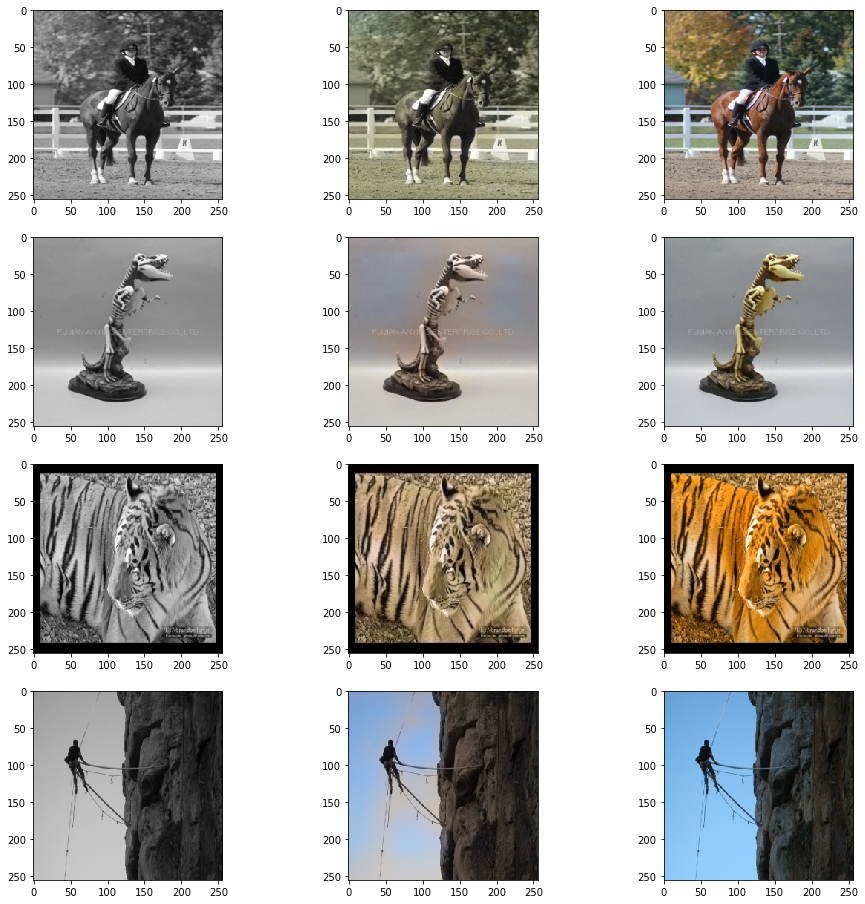

In [57]:
# Select random 4 results to display.
# Order: Input, Predicted, Ground Truth
# Assumes all three results folder have the 4 files

filelist = shuffle(os.listdir('result/predicted/'))
filelist = filelist[:4]

fig, ax = plt.subplots(4, 3, figsize=(16,16))
row = 0
for filename in filelist:
    folder = 'result/bnw/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255
    ax[row,0].imshow(image_in)
    
    folder = 'result/predicted/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255
    ax[row,1].imshow(image_in)
    
    folder = 'result/actual/'
    image_in = img_to_array(load_img(folder + filename))
    image_in = image_in/255
    ax[row,2].imshow(image_in)
    
    row += 1

### Learning Graphs

|Loss|Learning Rate|Validation Loss|
|:----:|:----:|:----:|
| <img src="resources/loss.png" style="height:150px; vertical-align:bottom; display:inline-block;"/> | <img src="resources/lr.png" style="height:150px; vertical-align:bottom; display:inline-block;"/> | <img src="resources/val_loss.png" style="height:150px; vertical-align:bottom; display:inline-block;"/> |

### Future Work

* Above network is made to run on a very small dataset due to time and resource contraints, In future, we will train on a larger dataset and compare result
* As seen in the Learning graphs, this network reaches learning saturation with quite a few training samples and doesn't generalize well just yet. We will do further enhancements to improve this situation.
* Generalize network input size so as to enable it to train on multiple resolution images
* Experiment using other pretrained models
* Can be extended to videos

### References

1. *Baldassarre, Morin and Lucas Rodes-Guirao.* __Deep Koalarization: Image Colorization using CNNs and Inception-Resnet-v2.__ [link](https://github.com/baldassarreFe/deep-koalarization/blob/master/paper.pdf)
2. *Iizuka, Satoshi, Edgar Simo-Serra, and Ishikawa Hiroshi.* __Let there be Color!__ *SIGGRAPH 2016*
3. *Larsson, Maire, and Shakhnarovich.* __Learning Representations for Automatic Colorization.__ *ECCV 2016*
4. *Zhang, Richard, Phillip Isola, and Alexei A. Efros.* __Colorful Image Colorization.__ *ECCV 2016*
5. http://www.whatimade.today/our-frst-reddit-bot-coloring-b-2/